Классификации SI > 8

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

# Настройка стиля для графиков
sns.set_style("whitegrid")

In [16]:
print("Загрузка обработанного датафрейма")
processed_excel_file = 'processed_compounds_data.xlsx'
df = pd.read_excel(processed_excel_file)

Загрузка обработанного датафрейма


In [17]:
# Создание целевой переменной для классификации SI > 8
print("Создание целевой переменной: SI > 8")

# Определяем порог для SI
SI_THRESHOLD = 8

# Создаем бинарную целевую переменную: 1, если SI > SI_THRESHOLD, иначе 0
# Важно: используем исходное значение SI, так как порог 8 дан в исходной шкале.
# df['SI_above_8_class'] = (df['SI'] > SI_THRESHOLD).astype(int)

# Однако, так как мы работали с log_SI в предыдущих задачах,
# логичнее использовать log_SI для последовательности, если данные SI сильно скошены.
# Давайте посмотрим на распределение SI и log_SI
# Если SI >> 0, то log10(SI) > log10(8) = 0.903
if 'log_SI' in df.columns:
    log_SI_THRESHOLD = np.log10(SI_THRESHOLD)
    print(f"Порог SI > {SI_THRESHOLD} в логарифмической шкале (log10): log_SI > {log_SI_THRESHOLD:.4f}")
    df['SI_above_8_class'] = (df['log_SI'] > log_SI_THRESHOLD).astype(int)
else:
    print("Столбец 'log_SI' не найден. Используем 'SI' напрямую. Рекомендуется использовать логарифмированные значения при наличии.")
    df['SI_above_8_class'] = (df['SI'] > SI_THRESHOLD).astype(int)

Создание целевой переменной: SI > 8
Порог SI > 8 в логарифмической шкале (log10): log_SI > 0.9031


In [18]:
print(f"Распределение классов для SI_above_{SI_THRESHOLD}_class:")
class_counts = df['SI_above_8_class'].value_counts(normalize=True)
print(class_counts)

Распределение классов для SI_above_8_class:
SI_above_8_class
0    0.643357
1    0.356643
Name: proportion, dtype: float64


In [19]:
# Проверка на несбалансированность классов
is_imbalanced = class_counts.min() < 0.3 or class_counts.max() > 0.7
if is_imbalanced:
    print("Классы несбалансированы! Это может повлиять на метрики и потребовать специальных подходов.")
    # Вычисляем веса классов для борьбы с несбалансированностью, если нужно
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['SI_above_8_class']),
        y=df['SI_above_8_class']
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Вычисленные веса классов: {class_weight_dict}")
else:
    print("Классы относительно сбалансированы.")
    class_weight_dict = None # Не используем веса, если классы сбалансированы

Классы относительно сбалансированы.


In [20]:
# Определяем список всех дескрипторов (признаков), исключая все целевые переменные
# (исходные, логарифмированные, и новые бинарные)
all_feature_columns = [
    col for col in df.columns
    if col not in ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50', 'log_CC50', 'log_SI',
                    'IC50_binary_class', 'CC50_binary_class', 'SI_binary_class', 'SI_above_8_class']
    and df[col].dtype in ['float64', 'int64']
]

print(f"Общее количество доступных признаков-дескрипторов для классификации: {len(all_feature_columns)}")

Общее количество доступных признаков-дескрипторов для классификации: 163


In [21]:
# Функция для оценки классификационной модели (переиспользована из предыдущего шага)
def evaluate_classifier(model, X_test, y_test, target_name, model_name):
    """
    Оценивает классификационную модель, выводит метрики и строит ROC-кривую.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Вероятности для ROC AUC

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Результаты для {model_name} (Классификация {target_name}) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("Матрица ошибок (Confusion Matrix):")
    # Строим матрицу ошибок, чтобы лучше видеть баланс
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['<=8', '>8'], yticklabels=['<=8', '>8'])
    plt.title(f'Confusion Matrix for {target_name} ({model_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    print("Отчет о классификации (Classification Report):")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Визуализация ROC-кривой
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {target_name} ({model_name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return {'model_name': model_name, 'target': target_name,
            'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
            'F1-score': f1, 'ROC AUC': roc_auc}

In [22]:
# Подготовка данных для классификации SI > 8
print(f"НАЧИНАЕМ КЛАССИФИКАЦИЮ ДЛЯ SI_above_{SI_THRESHOLD}_class ---")

# Создаем набор признаков, исключая IC50, CC50 и их логарифмированные/бинарные версии
# (так как SI не должен зависеть от них напрямую в данном контексте, хотя SI = CC50/IC50)
# Здесь мы предполагаем, что вы хотите предсказать SI на основе базовых дескрипторов
# без использования других целевых переменных.
X_si_gt8_clf_features = [col for col in all_feature_columns if 'IC50' not in col and 'CC50' not in col]
y_si_gt8_clf = df['SI_above_8_class']
X_si_gt8_clf = df[X_si_gt8_clf_features]

if not X_si_gt8_clf_features:
    print(f"Ошибка: Набор признаков для SI_above_{SI_THRESHOLD}_class пуст. Проверьте условия исключения.")
    exit()

# Разделение на обучающую и тестовую выборки с использованием стратификации
# Stratify очень важен для сохранения пропорций классов, особенно при несбалансированных классах.
X_train_si_gt8_clf, X_test_si_gt8_clf, y_train_si_gt8_clf, y_test_si_gt8_clf = train_test_split(
    X_si_gt8_clf, y_si_gt8_clf, test_size=0.2, random_state=42, stratify=y_si_gt8_clf
)

# Масштабирование признаков
scaler_si_gt8_clf = StandardScaler()
X_train_si_gt8_clf_scaled = scaler_si_gt8_clf.fit_transform(X_train_si_gt8_clf)
X_test_si_gt8_clf_scaled = scaler_si_gt8_clf.transform(X_test_si_gt8_clf)

НАЧИНАЕМ КЛАССИФИКАЦИЮ ДЛЯ SI_above_8_class ---


In [23]:
# Модели и настройка гиперпараметров
classification_results_si_gt8 = [] # Для сбора результатов этой задачи

# Общие параметры для GridSearchCV
grid_cv_params = {
    'cv': 5,
    'scoring': 'roc_auc',
    'n_jobs': -1,
    'verbose': 0
}

Настройка гиперпараметров для Logistic Regression (SI_above_8_class)
Лучшие гиперпараметры для Logistic Regression (SI > 8): {'C': 0.1}
Результаты для Logistic Regression (Классификация SI_above_8_class) ---
Accuracy: 0.6517
Precision: 0.5161
Recall: 0.4444
F1-score: 0.4776
ROC AUC: 0.6638
Матрица ошибок (Confusion Matrix):


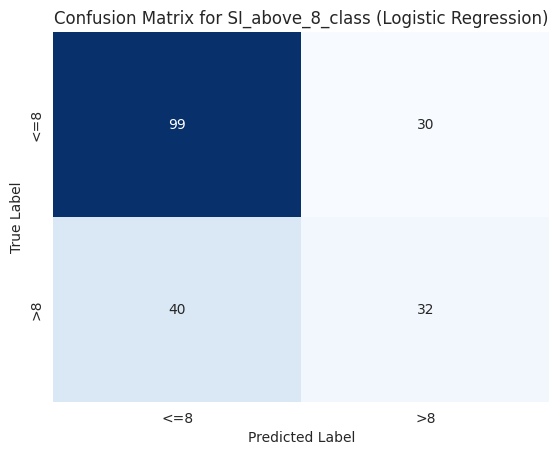

Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       129
           1       0.52      0.44      0.48        72

    accuracy                           0.65       201
   macro avg       0.61      0.61      0.61       201
weighted avg       0.64      0.65      0.65       201



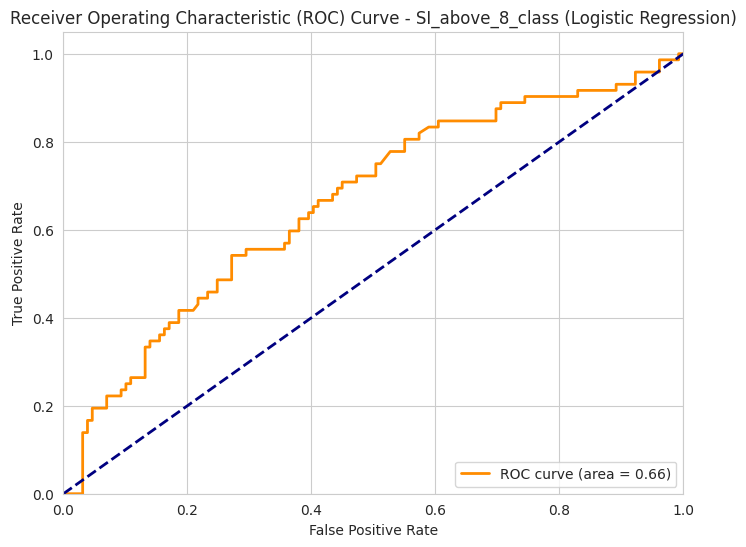

In [10]:
# 1. Logistic Regression
print(f"Настройка гиперпараметров для Logistic Regression (SI_above_{SI_THRESHOLD}_class)")
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
# Учитываем class_weight, если классы несбалансированы
lr_model = LogisticRegression(random_state=42, solver='liblinear', class_weight=class_weight_dict if is_imbalanced else None)
grid_search_lr_si_gt8 = GridSearchCV(lr_model, param_grid_lr, **grid_cv_params)
grid_search_lr_si_gt8.fit(X_train_si_gt8_clf_scaled, y_train_si_gt8_clf)
best_lr_si_gt8 = grid_search_lr_si_gt8.best_estimator_
print(f"Лучшие гиперпараметры для Logistic Regression (SI > {SI_THRESHOLD}): {grid_search_lr_si_gt8.best_params_}")
classification_results_si_gt8.append(evaluate_classifier(best_lr_si_gt8, X_test_si_gt8_clf_scaled, y_test_si_gt8_clf, f'SI_above_{SI_THRESHOLD}_class', 'Logistic Regression'))

Настройка гиперпараметров для Random Forest Classifier (SI_above_8_class)
Лучшие гиперпараметры для Random Forest (SI > 8): {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Результаты для Random Forest (Классификация SI_above_8_class) ---
Accuracy: 0.7214
Precision: 0.6429
Recall: 0.5000
F1-score: 0.5625
ROC AUC: 0.7382
Матрица ошибок (Confusion Matrix):


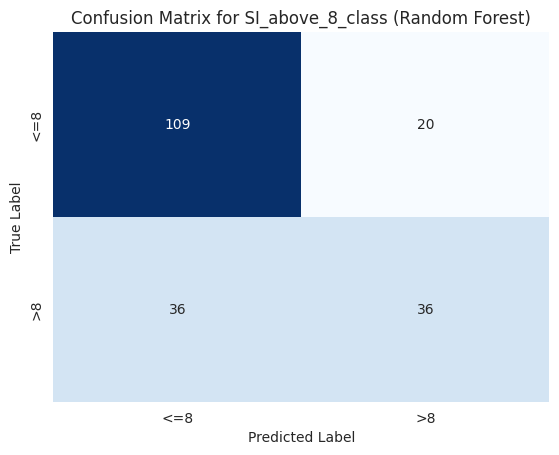

Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.75      0.84      0.80       129
           1       0.64      0.50      0.56        72

    accuracy                           0.72       201
   macro avg       0.70      0.67      0.68       201
weighted avg       0.71      0.72      0.71       201



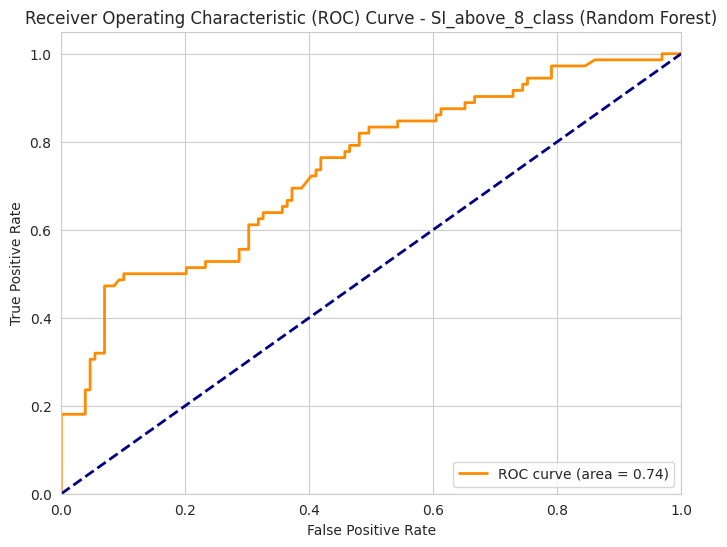

In [11]:
# 2. Random Forest Classifier
print(f"Настройка гиперпараметров для Random Forest Classifier (SI_above_{SI_THRESHOLD}_class)")
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Увеличение числа деревьев
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2]
}
# Учитываем class_weight, если классы несбалансированы
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced' if is_imbalanced else None)
grid_search_rf_si_gt8 = GridSearchCV(rf_model, param_grid_rf, **grid_cv_params)
grid_search_rf_si_gt8.fit(X_train_si_gt8_clf, y_train_si_gt8_clf)
best_rf_si_gt8 = grid_search_rf_si_gt8.best_estimator_
print(f"Лучшие гиперпараметры для Random Forest (SI > {SI_THRESHOLD}): {grid_search_rf_si_gt8.best_params_}")
classification_results_si_gt8.append(evaluate_classifier(best_rf_si_gt8, X_test_si_gt8_clf, y_test_si_gt8_clf, f'SI_above_{SI_THRESHOLD}_class', 'Random Forest'))


Настройка гиперпараметров для Gradient Boosting Classifier (SI_above_8_class)...
Лучшие гиперпараметры для Gradient Boosting (SI > 8): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Результаты для Gradient Boosting (Классификация SI_above_8_class) ---
Accuracy: 0.7264
Precision: 0.6604
Recall: 0.4861
F1-score: 0.5600
ROC AUC: 0.7479
Матрица ошибок (Confusion Matrix):


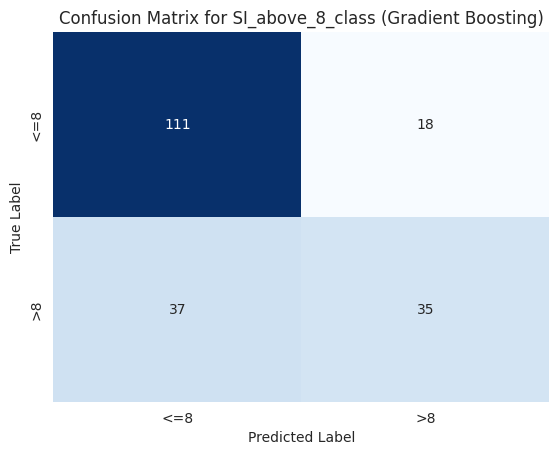

Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       129
           1       0.66      0.49      0.56        72

    accuracy                           0.73       201
   macro avg       0.71      0.67      0.68       201
weighted avg       0.72      0.73      0.71       201



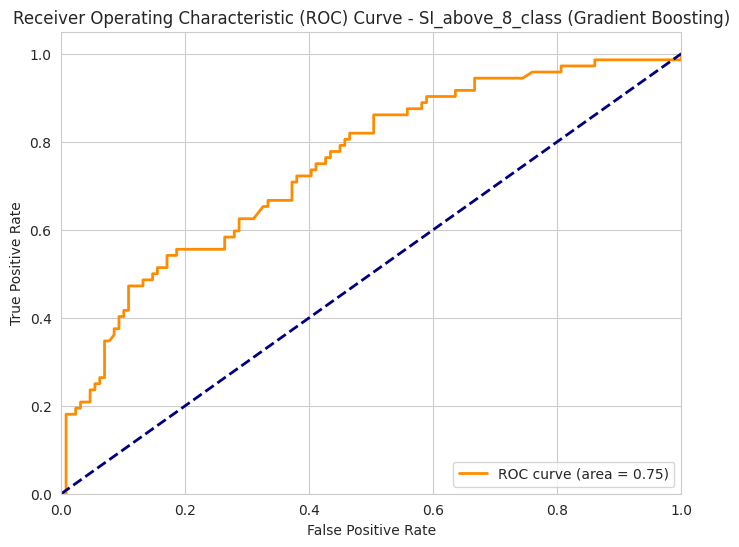

In [12]:
# 3. Gradient Boosting Classifier
print(f"Настройка гиперпараметров для Gradient Boosting Classifier (SI_above_{SI_THRESHOLD}_class)...")
param_grid_gb = {
    'n_estimators': [100, 200, 300], # Увеличение числа деревьев
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
# Gradient Boosting не имеет прямого параметра class_weight.
# Для несбалансированных данных можно использовать oversampling (SMOTE) или undersampling.
# Пока не будем применять, чтобы не усложнять, но это важный аспект для несбалансированности.
gb_model = GradientBoostingClassifier(random_state=42)
grid_search_gb_si_gt8 = GridSearchCV(gb_model, param_grid_gb, **grid_cv_params)
grid_search_gb_si_gt8.fit(X_train_si_gt8_clf, y_train_si_gt8_clf)
best_gb_si_gt8 = grid_search_gb_si_gt8.best_estimator_
print(f"Лучшие гиперпараметры для Gradient Boosting (SI > {SI_THRESHOLD}): {grid_search_gb_si_gt8.best_params_}")
classification_results_si_gt8.append(evaluate_classifier(best_gb_si_gt8, X_test_si_gt8_clf, y_test_si_gt8_clf, f'SI_above_{SI_THRESHOLD}_class', 'Gradient Boosting'))

Настройка гиперпараметров для XGBoost Classifier (SI_above_8_class)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:06:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшие гиперпараметры для XGBoost (SI > 8): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'use_label_encoder': False}
Результаты для XGBoost (Классификация SI_above_8_class) ---
Accuracy: 0.6866
Precision: 0.5714
Recall: 0.5000
F1-score: 0.5333
ROC AUC: 0.7066
Матрица ошибок (Confusion Matrix):


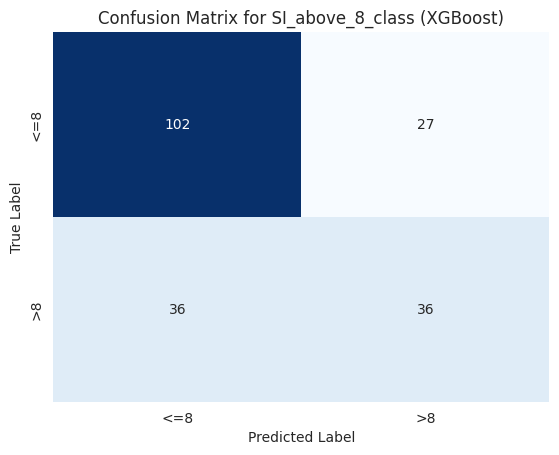

Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       129
           1       0.57      0.50      0.53        72

    accuracy                           0.69       201
   macro avg       0.66      0.65      0.65       201
weighted avg       0.68      0.69      0.68       201



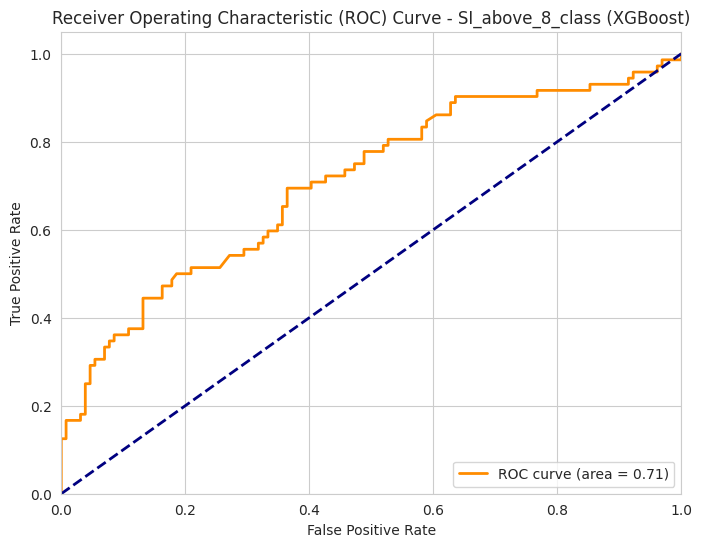

In [13]:
# 4. XGBoost Classifier
print(f"Настройка гиперпараметров для XGBoost Classifier (SI_above_{SI_THRESHOLD}_class)")
param_grid_xgb = {
    'n_estimators': [100, 200, 300], # Увеличение числа деревьев
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'use_label_encoder': [False]
}
# Для XGBoost можно использовать scale_pos_weight для несбалансированных классов
# scale_pos_weight = count(negative examples) / count(positive examples)
scale_pos_weight_val = class_weight_dict[0] / class_weight_dict[1] if is_imbalanced and class_weight_dict and class_weight_dict[1] != 0 else 1
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42,
                              scale_pos_weight=scale_pos_weight_val if is_imbalanced else 1)

grid_search_xgb_si_gt8 = GridSearchCV(xgb_model, param_grid_xgb, **grid_cv_params)
grid_search_xgb_si_gt8.fit(X_train_si_gt8_clf, y_train_si_gt8_clf)
best_xgb_si_gt8 = grid_search_xgb_si_gt8.best_estimator_
print(f"Лучшие гиперпараметры для XGBoost (SI > {SI_THRESHOLD}): {grid_search_xgb_si_gt8.best_params_}")
classification_results_si_gt8.append(evaluate_classifier(best_xgb_si_gt8, X_test_si_gt8_clf, y_test_si_gt8_clf, f'SI_above_{SI_THRESHOLD}_class', 'XGBoost'))

In [14]:
# таблица результатов для SI > 8
print('таблица результатов для SI > 8')
results_si_gt8_df = pd.DataFrame(classification_results_si_gt8)
results_si_gt8_df.sort_values(by='ROC AUC', ascending=False)

таблица результатов для SI > 8


,model_name,target,Accuracy,Precision,Recall,F1-score,ROC AUC
2,Gradient Boosting,SI_above_8_class,0.726368,0.660377,0.486111,0.560000,0.747901
1,Random Forest,SI_above_8_class,0.721393,0.642857,0.500000,0.562500,0.738211
3,XGBoost,SI_above_8_class,0.686567,0.571429,0.500000,0.533333,0.706557
0,Logistic Regression,SI_above_8_class,0.651741,0.516129,0.444444,0.477612,0.663814
